# Evaluating performance of scalable GPLVM models for dimensionality reduction of single-cell genomics datasets
---

In [32]:
from Functions import plot_cormap, scatter_Plot,CorrelationScores_PT,randScore, NMI_Scores, plot_umap,knn_purity, proliferation_purity
import scanpy as sc
import os, torch
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.sparse as sp
from collections import namedtuple
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import sklearn.metrics

In [2]:
## Load output of trained GPLVMs (14 in total)

In [18]:
gastrulation =sc.read_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/gastrulation.h5ad')
forebrain= sc.read_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/forebrain.h5ad')
bonemarrow= sc.read_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/bonemarrow.h5ad')
iPSC= sc.read_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/iPSC.h5ad')
pancreas= sc.read_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/pancreas.h5ad')
pbmc10k= sc.read_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/pbmc10k.h5ad')
pbmc3k= sc.read_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/pbmc3k.h5ad')

In [6]:
# gastrulation=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/gastrulation_PCA.h5ad')
# gastrulation_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/gastrulation_random.h5ad')
# forebrain=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/forebrain_PCA.h5ad')
# forebrain_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/forebrain_random.h5ad')
# bonemarrow=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/bonemarrow_PCA.h5ad')
# bonemarrow_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/bonemarrow_random.h5ad')
# iPSC=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/iPSC_PCA.h5ad')
# iPSC_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/iPSC_random.h5ad')
# pancreas=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/pancreas_PCA.h5ad')
# pancreas_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/pancreas_random.h5ad')
# pbmc10k=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/pbmc10k_pca.h5ad')
# pbmc10k_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/pbmc10k_random.h5ad')
# pbmc3k=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/pbmc3k_pca.h5ad')
# pbmc3k_random=sc.read_h5ad('/home/jovyan/GPLVM_Shaista/TrainedModels/pbmc3k_random.h5ad')

In [17]:
gastrulation=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/gastrulation_PCA.h5ad')
gastrulation_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/gastrulation_random.h5ad')
forebrain=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/forebrain_PCA.h5ad')
forebrain_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/forebrain_random.h5ad')
bonemarrow=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/bonemarrow_PCA.h5ad')
bonemarrow_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/bonemarrow_random.h5ad')
iPSC=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/iPSC_PCA.h5ad')
iPSC_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/iPSC_random.h5ad')
pancreas=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/pancreas_PCA.h5ad')
pancreas_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/pancreas_random.h5ad')
pbmc10k=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/pbmc10k_pca.h5ad')
pbmc10k_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/pbmc10k_random.h5ad')
pbmc3k=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/pbmc3k_pca.h5ad')
pbmc3k_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/pbmc3k_random.h5ad')

| Dataset     | Gastrulation|
| ----------- | ----------- |
| No of Cells | 89267        |
| No of Genes | 1488       |
|Time         | 9 minutes       |

| Dataset     | Forebrain|
| ----------- | ----------- |
| No of Cells | 1720       |
| No of Genes | 2454     |
|Time         | ~13 minutes       |

| Dataset     | Bonemarrow|
| ----------- | ----------- |
| No of Cells | 5780        |
| No of Genes |  2030|    |
|Time         |~12 mins        |

| Dataset     |iPSC|
| ----------- | ----------- |
| No of Cells |    22188    |
| No of Genes | 1404 |    |
|Time         |~8:50 mins        |

| Dataset     |Pancreas|
| ----------- | ----------- |
| No of Cells | 3696       |
| No of Genes | 1939 |    |
|Time         |~11 mins        |

| Dataset     |pbmc10k|
| ----------- | ----------- |
| No of Cells |    12016 |
| No of Genes | 4650   |
|Time         |~25 mins        |

## Do we require non-random initialization of the GPLVM model?

In the GASPACHO paper we used PCA as the inital state, but is this really necessary?

### 1. GPLVM initialized from the PCA doesn't learn anything different

In [18]:
## ... correlation between PCs and LVs with and without initialization

In [19]:
datasets=[bonemarrow,bonemarrow_random, forebrain,forebrain_random, gastrulation, gastrulation_random, pancreas
          ,pancreas_random,pbmc10k,pbmc10k_random, pbmc3k, pbmc3k_random]

Names=['bonemarrow','bonemarrow_random', 'forebrain','forebrain_random', 'gastrulation', 'gastrulation_random', 
       'pancreas','pancreas_random','pbmc10k','pbmc10k_random', "pbmc3k", "pbmc3k_random"]

data= pd.DataFrame(columns=["Correlation", "dataset", "Init"])

for i in range(len(datasets)):
    tempDf = pd.DataFrame(columns=['Correlation','dataset','Init'])
    #tempDf['Correlation'] = CorrelationScores_PT(datasets[i],7)
    tempDf = tempDf.assign(dataset=Names[i])
    if '_' in Names[i]:
        tempDf['Correlation'] = CorrelationScores_PT(datasets[i],7)
        tempDf = tempDf.assign(dataset=Names[i])
        tempDf= tempDf.assign(Init="random")
        data = pd.concat([data,tempDf])
    else:
        tempDf['Correlation'] = CorrelationScores_PT(datasets[i],7)
        tempDf = tempDf.assign(dataset=Names[i])
        tempDf= tempDf.assign(Init="PCA")
        data = pd.concat([data,tempDf])   

d=data.copy()
d=d.replace('pbmc10k_random','pbmc10k')
d=d.replace('bonemarrow_random','bonemarrow')
d=d.replace('forebrain_random','forebrain')
d=d.replace('pancreas_random','pancreas')
d=d.replace('gastrulation_random','gastrulation')
d=d.replace('pbmc3k_random','pbmc3k')
d.to_csv('Correlation_Scaled.csv')

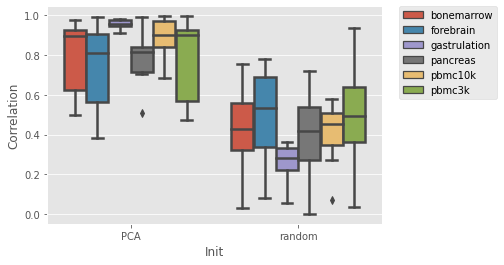

In [20]:
ax = sns.boxplot(x="Init", y="Correlation", hue="dataset",
                 data=d, linewidth=2.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### 2. Does GPLVM trained with random initialization capture cell type identity?

As a first impression we can visualize UMAP embeddings from all the dimensionality reductions (random GPLVM, initialized GPLM, PCA) and assess qualitatively if we see a separation between cells of the same cell type

In [ ]:
## code for UMAP plots ##

 #sc.tl.pca(adata, svd_solver='arpack')

#plot_umap(forebrain,forebrain_random)

#plot_umap(gastrulation, gastrulation_random)

#plot_umap(bonemarrow,bonemarrow_random)

#plot_umap(iPSC,iPSC_random)

#plot_umap(pbmc10k,pbmc10k_random)

#plot_umap(pancreas,pancreas_random)

#plot_umap(pbmc3k,pbmc3k_random)

AnnData object with n_obs × n_vars = 3012 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_ref.spca', 'X_ref.umap', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'log_norm_count'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

In [35]:
# # save everything once so don't have to rerun every time
# gastrulation.write_h5ad('/home/jovyan/GPLVM_Shaista/Benchmarking/gastrulation.h5ad')
# forebrain.write_h5ad('/home/jovyan/GPLVM_Shaista/Benchmarking/forebrain.h5ad')
# bonemarrow.write_h5ad('/home/jovyan/GPLVM_Shaista/Benchmarking/bonemarrow.h5ad')
# iPSC.write_h5ad('/home/jovyan/GPLVM_Shaista/Benchmarking/iPSC.h5ad')
# pancreas.write_h5ad('/home/jovyan/GPLVM_Shaista/Benchmarking/pancreas.h5ad')
# # pbmc10k.write_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/pbmc10k.h5ad')
# # pbmc3k.write_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/pbmc3k.h5ad')

In [21]:
forebrain.obs['celltype']=forebrain.obs['Clusters']
pancreas.obs['celltype']=pancreas.obs['clusters']
bonemarrow.obs['celltype']=bonemarrow.obs['clusters']
pancreas.obs['celltype']=pancreas.obs['clusters']
pbmc10k.obs['celltype']=pbmc10k.obs['predicted.celltype.l2']
pbmc3k.obs['celltype']=pbmc3k.obs['predicted.celltype.l2']

In [23]:
pbmc10k

AnnData object with n_obs × n_vars = 12016 × 4650
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit', 'celltype'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'PCA', 'gplvm_PCA', 'hvg', 'leiden', 'likelihood_state_dict', 'model_state_dict', 'pca', 'umap', 'predicted.celltype.l2_colors'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_ref.spca', 'X_ref.umap', 'X_umap', 'X_umap_gplvm_PC', 'X_umap_gplvm_random', 'X_umap_pca'
    varm: 'PCs'
    obsp: 'PCA_connectivities', 'PCA_distances', 'gplvm_PCA_connectivities', 'gplvm_PCA_distances'

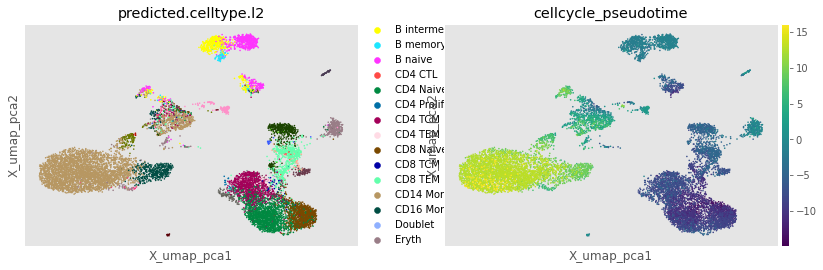

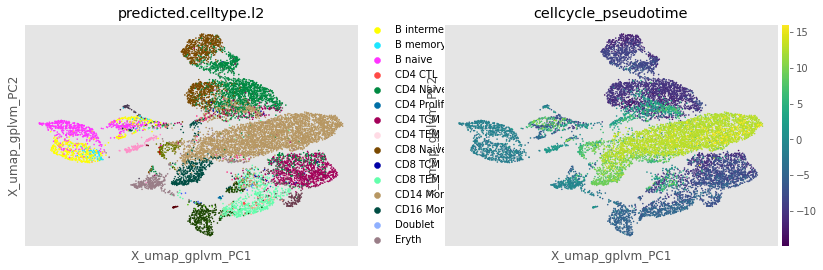

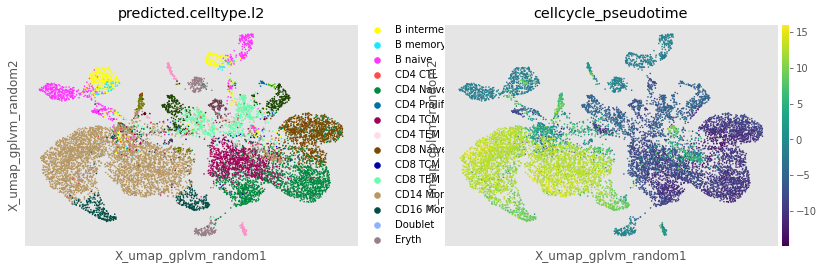

In [22]:
sc.pl.embedding(pbmc10k, "X_umap_pca", color=[ 'predicted.celltype.l2', 'cellcycle_pseudotime'])

sc.pl.embedding(pbmc10k, "X_umap_gplvm_PC", color=[ 'predicted.celltype.l2','cellcycle_pseudotime'])

sc.pl.embedding(pbmc10k, "X_umap_gplvm_random", color=[ 'predicted.celltype.l2','cellcycle_pseudotime'])

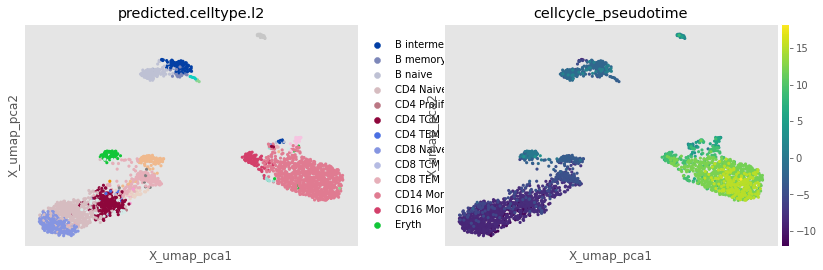

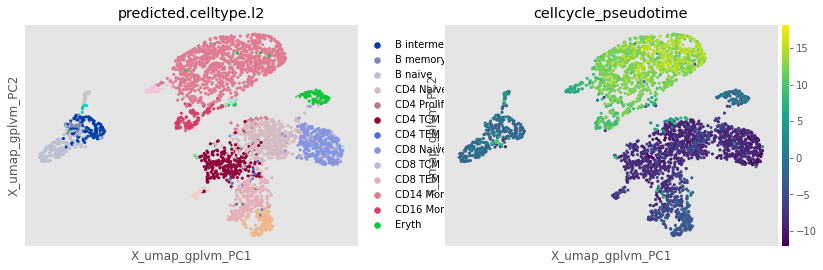

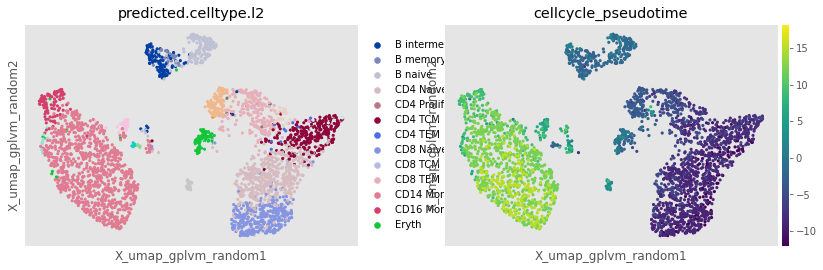

In [24]:
sc.pl.embedding(pbmc3k, "X_umap_pca", color=[ 'predicted.celltype.l2', 'cellcycle_pseudotime'])

sc.pl.embedding(pbmc3k, "X_umap_gplvm_PC", color=[ 'predicted.celltype.l2','cellcycle_pseudotime'])

sc.pl.embedding(pbmc3k, "X_umap_gplvm_random", color=[ 'predicted.celltype.l2','cellcycle_pseudotime'])

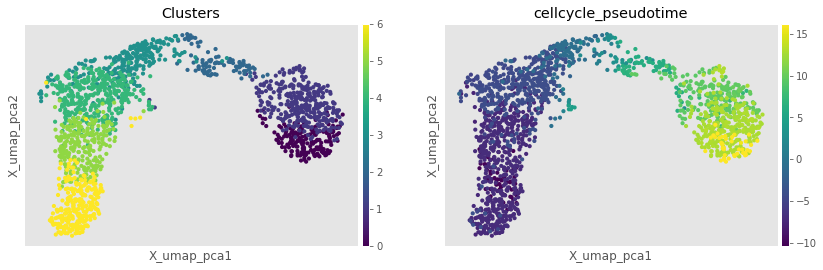

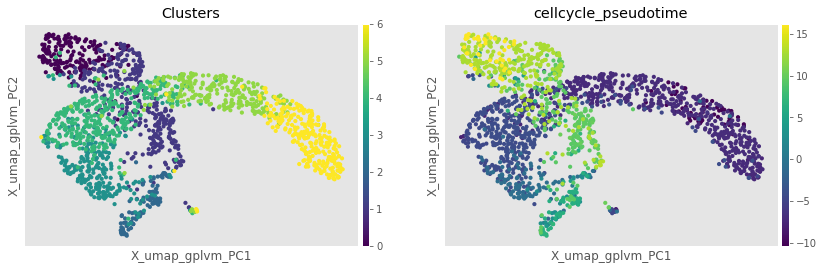

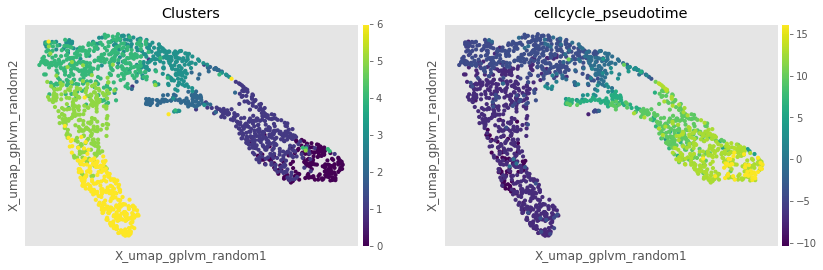

In [26]:
sc.pl.embedding(forebrain, "X_umap_pca", color=[ 'Clusters',"cellcycle_pseudotime"])

sc.pl.embedding(forebrain, "X_umap_gplvm_PC", color=[ 'Clusters', "cellcycle_pseudotime"])

sc.pl.embedding(forebrain, "X_umap_gplvm_random", color=['Clusters',"cellcycle_pseudotime"]) #PCA

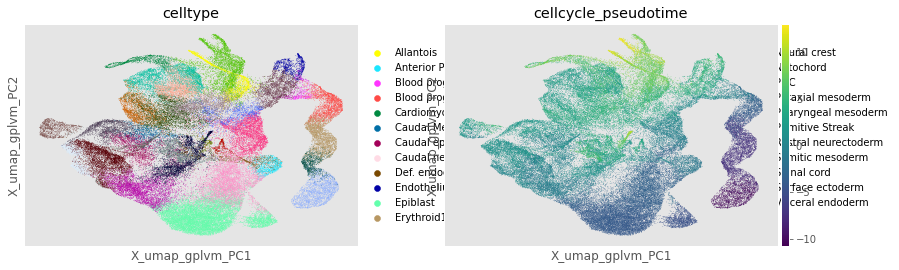

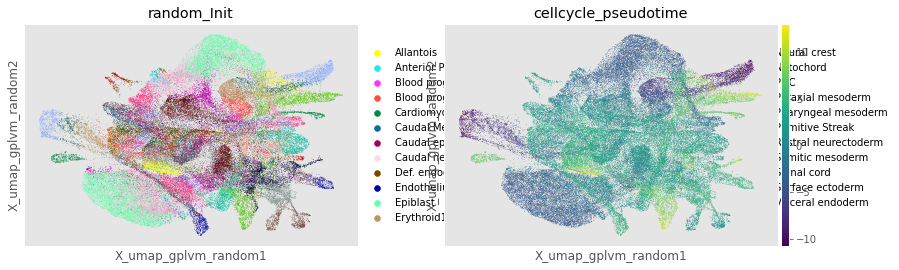

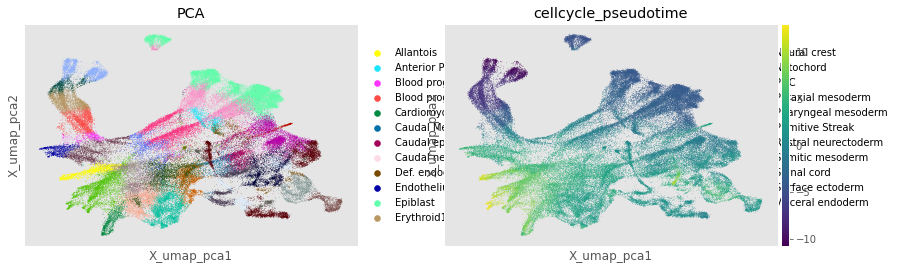

In [27]:
sc.pl.embedding(gastrulation, "X_umap_gplvm_PC", color=[ 'celltype', 'cellcycle_pseudotime'])#, title="PCA_Init")

sc.pl.embedding(gastrulation, "X_umap_gplvm_random", color=[ 'celltype','cellcycle_pseudotime'], title="random_Init")

sc.pl.embedding(gastrulation, "X_umap_pca", color=[ 'celltype','cellcycle_pseudotime'], title="PCA")

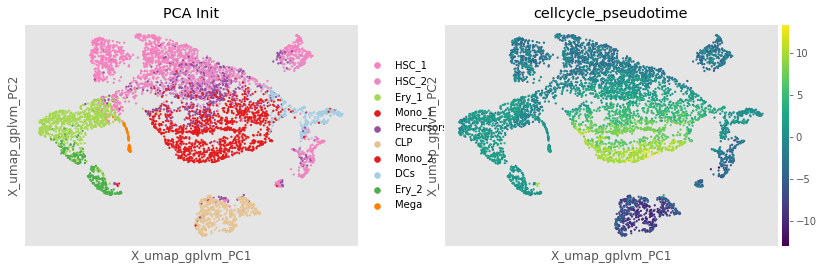

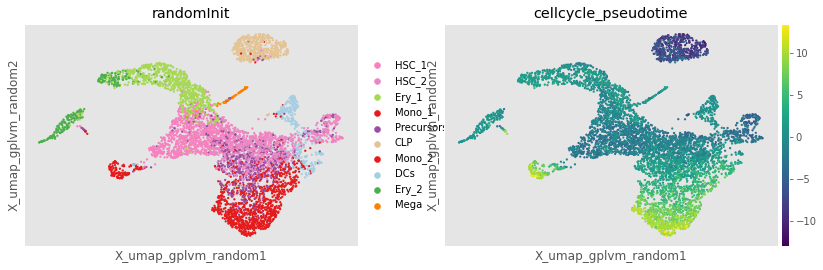

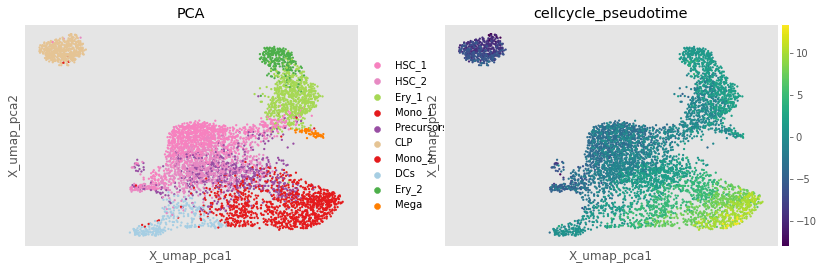

In [28]:
gp_pca=sc.pl.embedding(bonemarrow, "X_umap_gplvm_PC", color=['clusters',"cellcycle_pseudotime"], title="PCA Init")

gp_rand=sc.pl.embedding(bonemarrow, "X_umap_gplvm_random", color=[ 'clusters', "cellcycle_pseudotime"], title= "randomInit")

pca=sc.pl.embedding(bonemarrow, "X_umap_pca", color=[ 'clusters', "cellcycle_pseudotime"], title="PCA")

ARI and NMI

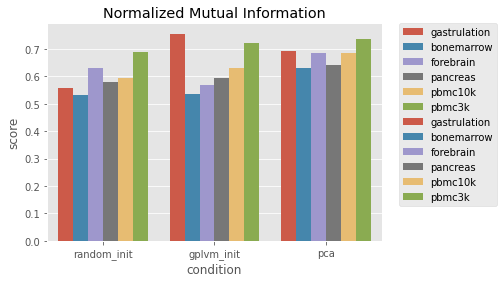

In [31]:
ds = [gastrulation,bonemarrow,forebrain, pancreas, pbmc10k, pbmc3k]
names= ['gastrulation','bonemarrow','forebrain', 'pancreas', 'pbmc10k', 'pbmc3k']
RandScore= pd.DataFrame(columns=['condition', 'score', 'dataset'] )
for i in range(len(ds)):
    adata = ds[i]
    name= names[i]
    RS = randScore(adata, name)
    #print(ARI)
    RandScore= pd.concat([RandScore,RS]) 
RandScore["Metric"]= "ARI"
    

ax = sns.barplot(x="condition", y="score", hue="dataset",
                 data=RandScore, linewidth=2.5)
#plt.legend(loc='upper left')
plt.title("Adjusted Rand Index")
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=3.)

ds = [gastrulation,bonemarrow,forebrain, pancreas, pbmc10k, pbmc3k]
NMI=pd.DataFrame(columns=['condition', 'score', 'dataset'] )
names= ['gastrulation','bonemarrow','forebrain', 'pancreas', 'pbmc10k', 'pbmc3k']
for i in range(len(ds)):
    adata = ds[i]
    name= names[i]
    Score = NMI_Scores(adata, name)
    #print(ARI)
    NMI= pd.concat([NMI,Score])
NMI["Metric"]= "NMI"

ax = sns.barplot(x="condition", y="score", hue="dataset",
                 data=NMI, linewidth=2.5)
#plt.legend(loc='upper left')
plt.title("Normalized Mutual Information")
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

FinalDataframe= pd.concat([RandScore,NMI])

FinalDataframe.to_csv('ARI_NMI.csv')

In [16]:
FinalDataframe

condition     score       dataset Metric
0  random_init  0.260815  gastrulation    ARI
1   gplvm_init  0.475603  gastrulation    ARI
2          pca  0.400743  gastrulation    ARI
0  random_init  0.320081    bonemarrow    ARI
1   gplvm_init  0.290114    bonemarrow    ARI
2          pca  0.513432    bonemarrow    ARI
0  random_init  0.447458     forebrain    ARI
1   gplvm_init  0.352767     forebrain    ARI
2          pca  0.521976     forebrain    ARI
0  random_init  0.318602      pancreas    ARI
1   gplvm_init  0.341344      pancreas    ARI
2          pca  0.446681      pancreas    ARI
0  random_init  0.297922       pbmc10k    ARI
1   gplvm_init  0.351820       pbmc10k    ARI
2          pca  0.473883       pbmc10k    ARI
0  random_init  0.380585        pbmc3k    ARI
1   gplvm_init  0.453452        pbmc3k    ARI
2          pca  0.530390        pbmc3k    ARI
0  random_init  0.559229  gastrulation    NMI
1   gplvm_init  0.755076  gastrulation    NMI
2          pca  0.694095  gastrulation    NMI
0  random_init  0.533229    bonemarrow    NMI
1   gplvm_init  0.537350    bonemarrow    NMI
2          pca  0.631125    bonemarrow    NMI
0  random_init  0.632026     forebrain    NMI
1   gplvm_init  0.567295     forebrain    NMI
2          pca  0.683863     forebrain    NMI
0  random_init  0.580684      pancreas    NMI
1   gplvm_init  0.595592      pancreas    NMI
2          pca  0.639743      pancreas    NMI
0  random_init  0.593535       pbmc10k    NMI
1   gplvm_init  0.631740       pbmc10k    NMI
2          pca  0.684979       pbmc10k    NMI
0  random_init  0.688927        pbmc3k    NMI
1   gplvm_init  0.720758        pbmc3k    NMI
2          pca  0.736289        pbmc3k    NMI

In [33]:
datasets=[ pancreas, forebrain, bonemarrow, pbmc10k, pbmc3k]
for i in range(len(datasets)):
    knn_purity(datasets[i], "X_umap_pca", 'celltype')
    knn_purity(datasets[i], "X_umap_gplvm_random", 'celltype')
    knn_purity(datasets[i], "X_umap_gplvm_PC", 'celltype')


https://stackoverflow.com/questions/14604439/plot-multiple-boxplot-in-one-graph

In [34]:
forebrain.obs['celltype'] = pd.Categorical(forebrain.obs.celltype)

In [36]:
# #save everything once so don't have to rerun every time
# forebrain.write_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/forebrain_knn.h5ad')
# bonemarrow.write_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/bonemarrow_knn.h5ad')
# pancreas.write_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/pancreas_knn.h5ad')
# pbmc10k.write_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/pbmc10k_knn.h5ad')
# pbmc3k.write_h5ad('/home/jupyter/GPLVM_Shaista/Benchmarking/pbmc3k_knn.h5ad')

Plk1 is an early trigger for G2/M transition. Plk1 supports the functional maturation of the centrosome in late G2/early prophase and establishment of the bipolar spindle. 

## Part 2: incorporating a latent variable with periodic prior in the GPLVM model allows to correct cell cycle effects

Having shown that GPLVMs (either with or without initialization) can perform the same tasks that PCA performs on scRNA-seq datasets, we now turn to evaluating the advantages of this model. One of the main advantages is that we can assign informative priors on some of the latent variables to better disentangle nuisance effects in gene expression data. One such effect is the cell cycle: by incorporating a latent variable with periodic kernel, we force that variable to capture the main "cyclic" effect in the dataset.

### 1. Does the variable with periodic kernel really capture the cell cycle?
Remember the model has no idea what the cell cycle is or which genes are related to it

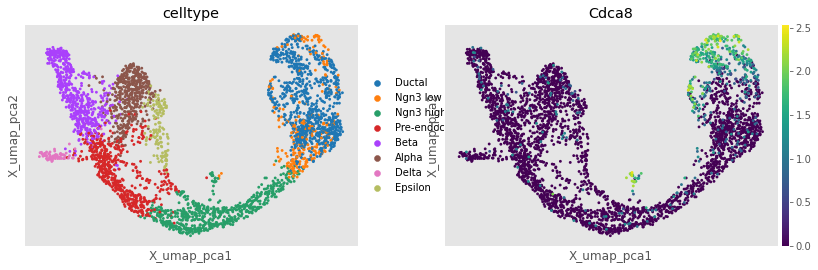

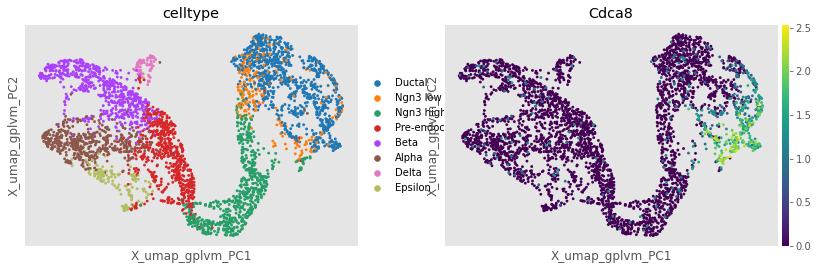

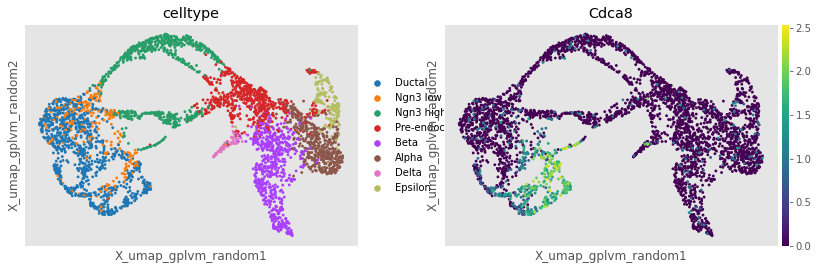

In [27]:
sc.pl.embedding(pancreas, "X_umap_pca", color=['celltype','Cdca8']) #PCA

gp_pca=sc.pl.embedding(pancreas, "X_umap_gplvm_PC", color=['celltype', "Cdca8"])

sc.pl.embedding(pancreas, "X_umap_gplvm_random", color=['celltype','Cdca8']) #PCA

# gp_pca=sc.pl.embedding(pancreas, "X_umap_pca", color=['clusters','Aurka'], title="PCA")
#'Plk1', "Aurka", 'Cdca8','Cenpe','Ube2c','Tpx2','Kpna2','Kif23','Cks2','Top2a' ,'Cenpf','Arl6ip1','Cdk1','Ccna2'

# gp_pca=sc.pl.embedding(iPSC, "X_umap_gplvm_PC", color=['cellcycle_pseudotime'], title="PCA Init")

# gp_pca=sc.pl.embedding(iPSC, "X_umap_pca", color=['cellcycle_pseudotime'], title="PCA")

# gp_pca=sc.pl.embedding(iPSC, "X_umap_gplvm_random", color=['cellcycle_pseudotime'], title="PCA")

In [35]:
Expression_Matrix=(pancreas.X).todense()

In [36]:
genes_pancreas= [ 'Plk1', "Aurka", 'Cdca8','Cenpe','Ube2c','Tpx2','Kpna2','Kif23','Cks2','Top2a' ,'Cenpf','Arl6ip1','Cdk1','Ccna2']
CellCyclepancreas=pancreas[:, ['Plk1', "Aurka", 'Cdca8','Cenpe','Ube2c','Tpx2','Kpna2','Kif23','Cks2','Top2a' ,'Cenpf','Arl6ip1','Cdk1','Ccna2']].to_df()

In [37]:

def proliferation_purity(adata, X_dim_red, gene_name, k=100):
    '''
    Params:
    -------
    - adata: AnnData object
    - X_dim_red: string of slot opf adata.obsm to use for knn graph construction
    - gene_name: string of name of the cellcylce gene used as a proxy for proliferation rate of cellsg
    
    - k: number of nearest neighbors (default: k=100)
    '''
        ## Find k nearest neighbors    
    sc.pp.neighbors(adata, n_neighbors=k, key_added='prolif_purity', use_rep=X_dim_red)
    bin_knn_mat=adata.obsp['prolif_purity_connectivities'].copy()
    bin_knn_mat[bin_knn_mat.nonzero()] = 1 
    bin_knn_mat = bin_knn_mat.toarray()
    df = adata[:, gene_name].to_df()
    def expression(x):
        if x <.1:
            return "low"
        if (x >= .1) and (x< 1.5):
            return "medium"
        if x >=1.5:
            return "high"
        return 

    for col in df.columns:
        df[col] = df[col].apply(lambda x: expression(x))
    proliferation_status=df[gene_name]
    proliferation_status=proliferation_status.to_numpy()
    #proliferation_status

    adata.obs['profliferation_purity_' + X_dim_red] = np.nan

    for i in range(bin_knn_mat.shape[0]):
            nn_labels = proliferation_status[bin_knn_mat[i,:].flatten()==1]
            knn_purity = sum(nn_labels == proliferation_status[i])/len(nn_labels)
            adata.obs.loc[adata.obs_names[i], 'proliferation_purity_' + X_dim_red] = knn_purity



In [30]:
l= ["PLK1", "TOP2A"]

In [31]:
proliferation_purity(forebrain, "X_umap_pca", "PLK1")

In [32]:
forebrain.obs['proliferation_purity_X_umap_pca']

CellID
10X_17_028:AACCATGGTAATCACCx    0.968992
10X_17_028:AACCATGCATACTACGx    0.964602
10X_17_028:AAACCTGGTAAAGGAGx    0.970803
10X_17_028:AAAGTAGCAAAGTCAAx    0.992701
10X_17_028:AAAGCAACAAACGCGAx    1.000000
                                  ...   
10X_17_029:TTTATGCGTTGCGCACx    0.968750
10X_17_029:TTTGCGCGTTCCGTCTx    0.981308
10X_17_029:TTTGGTTGTACCCAATx    1.000000
10X_17_029:TTTCCTCCAGTCCTTCx    0.979798
10X_17_029:TTTGCGCCACAGATTCx    0.008264
Name: proliferation_purity_X_umap_pca, Length: 1720, dtype: float64

In [33]:
#  ## Find k nearest neighbors    
# sc.pp.neighbors(adata, n_neighbors=100, key_added='prolif_purity', use_rep=X_dim_red)
# bin_knn_mat=adata.obsp['prolif_purity_connectivities'].copy()
# bin_knn_mat[bin_knn_mat.nonzero()] = 1 
# bin_knn_mat = bin_knn_mat.toarray()
# def expression(x):
#     if x <.1:
#         return "low"
#     if (x >= .1) and (x< 1.5):
#         return "medium"
#     if x >=1.5:
#         return "high"
#     return "Success"

# for col in df.columns:
#     df[col] = df[col].apply(lambda x: expression(x))
# df = adata[:, gene_list].to_df()
# proliferation_status=df[gene_name]
# proliferation_status=proliferation_status.to_numpy()
# #proliferation_status

# adtaa.obs['profliferation_purity_' + X_dim_red] = np.nan

# for i in range(bin_knn_mat.shape[0]):
#         nn_labels = proliferation_status[bin_knn_mat[i,:].flatten()==1]
#         knn_purity = sum(nn_labels == proliferation_status[i])/len(nn_labels)
#         adata.obs.loc[adata.obs_names[i], 'proliferation_purity_' + X_dim_red] = knn_purity



In [34]:
# df = pancreas[:, gene_list].to_df()
# def expression(x):
#     if x <.1:
#         return "low"
#     if (x >= .1) and (x< 1.5):
#         return "medium"
#     if x >=1.5:
#         return "high"
#     return "Success"

# for col in df.columns:
#     df[col] = df[col].apply(lambda x: expression(x))

# proliferation_status=df['Cks2']

# # sum(proliferation_status=='high')

# # CellCyclepancreas.max()
# proliferation_status=proliferation_status.to_numpy()
# #proliferation_status

# pancreas.obs['profliferation_purity_' + 'X_umap_pca'] = np.nan

# for i in range(bin_knn_mat.shape[0]):
#         nn_labels = proliferation_status[bin_knn_mat[i,:].flatten()==1]
#         knn_purity = sum(nn_labels == proliferation_status[i])/len(nn_labels)
#         pancreas.obs.loc[pancreas.obs_names[i], 'proliferation_purity_' + 'X_umap_pca'] = knn_purity

## Plot scatter plots or heatmap of cell cycle pseudotime VS expression of cell cycle genes 
1)Fn1
2)Mapk13
3)Aurka
4)Top2a
5)Cenpf
6)Arl6ip1
7)Cdk1

Reference: https://cyclebase.org/Advanced%20Search
        

https://pubmed.ncbi.nlm.nih.gov/26142758/
https://satijalab.org/seurat/archive/v3.1/cell_cycle_vignette.html
"PCNA", "TOP2A", "MCM6", "MKI67"

In [29]:
CELLCYCLE=['CCNF', 'PLK1', 'MAPK13', "AURKA", 'CDC8','HJURP','CENPE','UBE2C','TPX2','KPNA2','KIF23','CKS2','TOP2A','BUB1','DTL' ,'CENPF','ARL6IP1','CDK1','CCNA2','DLGAP5',"FN1","PCNA", "MCM6", "MKI67"]
CellCycle=['Ccnf', 'Plk1', 'Mapk13', "Aurka", 'Cdca8','Hjurp','Cenpe','Ube2c','Tpx2','Kpna2','Kif23','Cks2','Top2a','Bub1','Dtl' ,'Cenpf','Arl6ip1','Cdk1','Ccna2','Dlgap5', "Fn1", "Pcna", "Mcm6", "Mki67"]

HumanCellCycle='Ccnf',
'Plk1', M
'Mapk13': M
"Aurka", M
'Cenpe','M
'Tpx2','M
'Cks2',M
'Bub1',M
'Cenpf',M
'Arl6ip1',M
'Dlgap5', M

'Dtl' ,G1'

Kpna2',G2/M
'Cdca8',G2
'Hjurp',G2
Ube2c',G2
'Kif23',G2
'Top2a',G2
'Cdk1',G2
'Ccna2',G2

"Fn1"

In [30]:
M_Genes=['Plk1', 
        'Mapk13',
        "Aurka", 
        'Cenpe',
        'Tpx2',
        'Cks2',
        'Bub1',
        'Cenpf',
        'Arl6ip1',
        'Dlgap5']
M_Cap=[]
for i in range(len(M_Genes)):
    M_Cap.append(M_Genes[i].upper())

G2_Genes= [ 'Kpna2',
            'Cdca8',
            'Hjurp',
            'Ube2c',
            'Kif23',
            'Top2a',
            'Cdk1',
            'Ccna2']
G2_Cap=[]
for i in range(len(G2_Genes)):
    G2_Cap.append(G2_Genes[i].upper())


In [34]:
genes_pancreas=list(set(pancreas.var.index) & set(CellCycle))
CellCyclePancreas=pancreas[:, genes_pancreas].to_df()

genes_gastrulation=list(set(gastrulation.var.index) & set(CellCycle))
CellCycleGastrulation=gastrulation[:, genes_gastrulation].to_df()

genes_bonemarrow=list(set(bonemarrow.var.index) & set(CELLCYCLE))
CellCycleBonemarrow=bonemarrow[:, genes_bonemarrow].to_df()

genes_forebrain=list(set(forebrain.var.index) & set(CELLCYCLE))
CellCycleForebrain=forebrain[:, genes_forebrain].to_df()

genes_pbmc10k=list(set(pbmc10k.var.index) & set(CELLCYCLE))
CellCyclePbmc10k=pbmc10k[:, genes_pbmc10k].to_df()



genes_pbmc3k=list(set(pbmc3k.var.index) & set(CELLCYCLE))
CellCyclePbmc3k=pbmc3k[:, genes_pbmc3k].to_df()






In [35]:
# CellCycleFB=forebrain[:, ["PLK1",'CENPE', 'UBE2C','TPX2','KPNA2','CKS2','TOP2A','CENPF','ARL6IP1','CDK1','CCNA2']].to_df()
# FB_genes=["PLK1",'CENPE', 'UBE2C','TPX2','KPNA2','CKS2','TOP2A','CENPF','ARL6IP1','CDK1','CCNA2']
# fb_genes=[]
# for i in range(len(FB_genes)):
#     fb_genes.append(FB_genes[i].lower())

In [36]:
#pbmc10k
PBMC10K_G2=list(set(pbmc10k.var.index) & set(G2_Cap))
PBMC10K_M= list(set(pbmc10k.var.index) & set(M_Cap))

#pbmc3k
PBMC3K_G2=list(set(pbmc3k.var.index) & set(G2_Cap))
PBMC3K_M= list(set(pbmc3k.var.index) & set(M_Cap))

#bonemarrow

Bonemarrow_G2=list(set(bonemarrow.var.index) & set(G2_Cap))
Bonemarrow_M= list(set(bonemarrow.var.index) & set(M_Cap))

#Forebrain

Forebrain_G2=list(set(forebrain.var.index) & set(G2_Cap))
Forebrain_M= list(set(forebrain.var.index) & set(M_Cap))


#Gastrulation
Gastrulation_G2= list(set(gastrulation.var.index) & set(G2_Genes))
Gastrulation_G2= [each_gene.upper() for each_gene in Gastrulation_G2]
Gastrulation_M=list(set(gastrulation.var.index) & set(M_Genes))
Gastrulation_M= [each_gene.upper() for each_gene in Gastrulation_M]

#pancreas
Pancreas_G2= list(set(pancreas.var.index) & set(G2_Genes))
Pancreas_G2= [each_gene.upper() for each_gene in Pancreas_G2]
Pancreas_M=list(set(pancreas.var.index) & set(M_Genes))
Pancreas_M= [each_gene.upper() for each_gene in Pancreas_M]



In [79]:
Data= pd.DataFrame()
Data_G= pd.DataFrame({"CellCycle_Total":CELLCYCLE})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)

Data_G= pd.DataFrame({"MPhase":M_Cap})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)

Data_G= pd.DataFrame({"GPhase":G2_Cap})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)

Data_G= pd.DataFrame({"Pancreas_M":Pancreas_M})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)
Data_G= pd.DataFrame({"Pancreas_G2":Pancreas_G2})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)

Data_G= pd.DataFrame({"Gastrulation_M":Gastrulation_M})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1) 
Data_G= pd.DataFrame({"Gastrulation_G2":Gastrulation_G2})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1) 
Data_G= pd.DataFrame({"Forebrain_M":Forebrain_M})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1) 
Data_G= pd.DataFrame({"Forebrain_G2":Forebrain_G2})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)
Data_G= pd.DataFrame({"Bonemarrow_M":Bonemarrow_M})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)
Data_G= pd.DataFrame({"Bonemarrow_G2":Bonemarrow_G2})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)
Data_G= pd.DataFrame({"Pbmc10k_M":PBMC10K_M})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)
Data_G= pd.DataFrame({"Pbmc10k_G2":PBMC10K_G2})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)
Data_G= pd.DataFrame({"Pbmc3K_M":PBMC3K_M})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)
Data_G= pd.DataFrame({"Pbmc3K_G2":PBMC3K_G2})
Data = pd.concat([Data, Data_G], ignore_index=False, axis=1)



In [80]:
Data

CellCycle_Total   MPhase GPhase Pancreas_M Pancreas_G2 Gastrulation_M  \
0             CCNF     PLK1  KPNA2       CKS2       CDCA8         MAPK13   
1             PLK1   MAPK13  CDCA8      AURKA       TOP2A          CENPF   
2           MAPK13    AURKA  HJURP    ARL6IP1        CDK1          AURKA   
3            AURKA    CENPE  UBE2C      CENPF       KPNA2        ARL6IP1   
4             CDC8     TPX2  KIF23      CENPE       CCNA2            NaN   
5            HJURP     CKS2  TOP2A       TPX2       KIF23            NaN   
6            CENPE     BUB1   CDK1       PLK1       UBE2C            NaN   
7            UBE2C    CENPF  CCNA2        NaN         NaN            NaN   
8             TPX2  ARL6IP1    NaN        NaN         NaN            NaN   
9            KPNA2   DLGAP5    NaN        NaN         NaN            NaN   
10           KIF23      NaN    NaN        NaN         NaN            NaN   
11            CKS2      NaN    NaN        NaN         NaN            NaN   
12           TOP2A      NaN    NaN        NaN         NaN            NaN   
13            BUB1      NaN    NaN        NaN         NaN            NaN   
14             DTL      NaN    NaN        NaN         NaN            NaN   
15           CENPF      NaN    NaN        NaN         NaN            NaN   
16         ARL6IP1      NaN    NaN        NaN         NaN            NaN   
17            CDK1      NaN    NaN        NaN         NaN            NaN   
18           CCNA2      NaN    NaN        NaN         NaN            NaN   
19          DLGAP5      NaN    NaN        NaN         NaN            NaN   
20             FN1      NaN    NaN        NaN         NaN            NaN   
21            PCNA      NaN    NaN        NaN         NaN            NaN   
22            MCM6      NaN    NaN        NaN         NaN            NaN   
23           MKI67      NaN    NaN        NaN         NaN            NaN   

   Gastrulation_G2 Forebrain_M Forebrain_G2  Bonemarrow_M  Bonemarrow_G2  \
0             CDK1        CKS2        TOP2A           NaN            NaN   
1            TOP2A       CENPE         CDK1           NaN            NaN   
2              NaN        TPX2        CCNA2           NaN            NaN   
3              NaN       CENPF        KPNA2           NaN            NaN   
4              NaN        PLK1        UBE2C           NaN            NaN   
5              NaN     ARL6IP1          NaN           NaN            NaN   
6              NaN         NaN          NaN           NaN            NaN   
7              NaN         NaN          NaN           NaN            NaN   
8              NaN         NaN          NaN           NaN            NaN   
9              NaN         NaN          NaN           NaN            NaN   
10             NaN         NaN          NaN           NaN            NaN   
11             NaN         NaN          NaN           NaN            NaN   
12             NaN         NaN          NaN           NaN            NaN   
13             NaN         NaN          NaN           NaN            NaN   
14             NaN         NaN          NaN           NaN            NaN   
15             NaN         NaN          NaN           NaN            NaN   
16             NaN         NaN          NaN           NaN            NaN   
17             NaN         NaN          NaN           NaN            NaN   
18             NaN         NaN          NaN           NaN            NaN   
19             NaN         NaN          NaN           NaN            NaN   
20             NaN         NaN          NaN           NaN            NaN   
21             NaN         NaN          NaN           NaN            NaN   
22             NaN         NaN          NaN           NaN            NaN   
23             NaN         NaN          NaN           NaN            NaN   

   Pbmc10k_M Pbmc10k_G2 Pbmc3K_M Pbmc3K_G2  
0     MAPK13      TOP2A    CENPF     TOP2A  
1      AURKA        NaN      NaN       NaN  
2      CENPF        NaN      NaN       NaN  
3        NaN        N

In [91]:
from scanpy import read_h5ad
import scvelo as scv 
adata = read_h5ad('/home/jupyter/mount/gdrive/BridgeIntegrationData/Data/pbmc10k.h5ad')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata_pbmc3k = sc.read_h5ad('/home/jupyter/data/pbmc3k.h5ad')
sc.pp.normalize_total(adata_pbmc3k, target_sum=1e4)
sc.pp.log1p(adata_pbmc3k)

adata_gastrulation= scv.datasets.gastrulation()
sc.pp.normalize_total(adata_gastrulation, target_sum=1e4)
sc.pp.log1p(adata_gastrulation)

adata_gastrulation= scv.datasets.gastrulation()
sc.pp.normalize_total(adata_gastrulation, target_sum=1e4)
sc.pp.log1p(adata_gastrulation)

adata_pancreas= scv.datasets.gastrulation()
sc.pp.normalize_total(adata_gastrulation, target_sum=1e4)
sc.pp.log1p(adata_gastrulation)

adata_gastrulation= scv.datasets.gastrulation()
sc.pp.normalize_total(adata_gastrulation, target_sum=1e4)
sc.pp.log1p(adata_gastrulation)

adata_gastrulation= scv.datasets.gastrulation()
sc.pp.normalize_total(adata_gastrulation, target_sum=1e4)
sc.pp.log1p(adata_gastrulation)


AnnDataReadError: Above error raised while reading key '/layers/spliced' of type <class 'h5py._hl.group.Group'> from /.

In [82]:
#Data.to_csv('CellCycleGenes.csv')

In [1]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [2]:
%load_ext rpy2.ipython

/opt/conda/envs/gplvm_env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
datasets=[gastrulation, pancreas, forebrain, pbmc10k, pbmc3k]

NameError: name 'gastrulation' is not defined

In [96]:
plt.scatter( forebrain.obs['cellcycle_pseudotime'],forebrain[:,["AURKA"]].to_df(), s=1 )#G1 Phase gene 
plt.title("forebrain")
plt.xlabel('pseudotime')
plt.ylabel('gene expression')

KeyError: "Values ['AURKA'], from ['AURKA'], are not valid obs/ var names or indices."

Text(0, 0.5, 'gene expression')

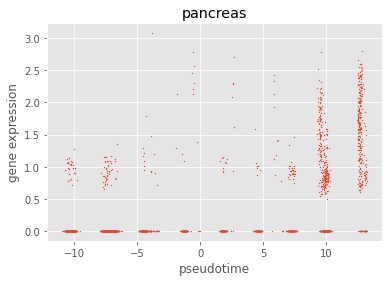

In [40]:
plt.scatter( pancreas.obs['cellcycle_pseudotime'],pancreas[:,["Cdk1"]].to_df(), s=.7 )#G1 Phase gene 
plt.title("pancreas")
plt.xlabel('pseudotime')
plt.ylabel('gene expression')

Text(0, 0.5, 'gene expression')

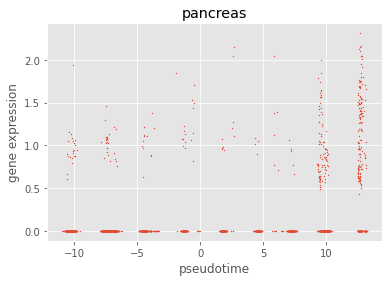

In [39]:
plt.scatter( pancreas.obs['cellcycle_pseudotime'],pancreas[:,["Aurka"]].to_df(), s=.7 )#G1 Phase gene 
plt.title("pancreas")
plt.xlabel('pseudotime')
plt.ylabel('gene expression')

Text(0, 0.5, 'gene expression')

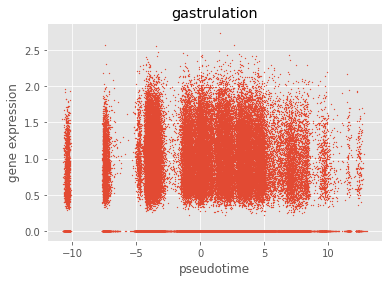

In [93]:
plt.scatter(gastrulation.obs['cellcycle_pseudotime'],adata_gastrulation[:,["Plk1"]].to_df(), s=.7 )#G1 Phase gene 
plt.title("gastrulation")
plt.xlabel('pseudotime')
plt.ylabel('gene expression')
    

In [94]:
plt.scatter(pbmc10k.obs['cellcycle_pseudotime'],adata_pbmc10k[:,["PLK1"]].to_df(), s=1 )#G1 Phase gene 
plt.title("pbmc10k")
plt.xlabel('pseudotime')
plt.ylabel('gene expression')

NameError: name 'adata_pbmc10k' is not defined

Text(0, 0.5, 'gene expression')

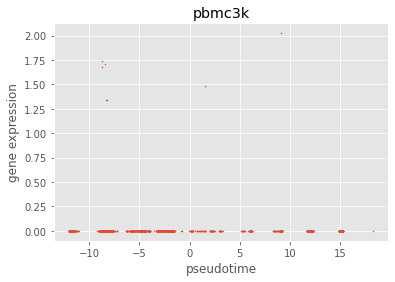

In [95]:
plt.scatter(pbmc3k.obs['cellcycle_pseudotime'],adata_pbmc3k[:,["PLK1"]].to_df(), s=1 )#G1 Phase gene 
plt.title("pbmc3k")
plt.xlabel('pseudotime')
plt.ylabel('gene expression')

In [ ]:
plt.scatter(gastrulation.obs['cellcycle_pseudotime'],gastrulation[:,["Top2a"]].to_df(), s=.1 )#G1 Phase gene 
plt.title("gastrulation")
plt.xlabel('pseudotime')
plt.ylabel('gene expression')

In [168]:
CellCyclegastrulation= gastrulation[:, ['Mapk13', "Aurka", 'Top2a','Cenpf','Arl6ip1','Cdk1']].to_df()

In [23]:
plt.scatter( gastrulation.obs['cellcycle_pseudotime'],CellCyclegastrulation["Mapk13"], s=1 )#G1 Phase gene 
plt.title('Mapk13')
plt.xlabel('psudotime')
plt.ylabel('gene expression')

NameError: name 'CellCyclegastrulation' is not defined

Text(0, 0.5, 'gene expression')

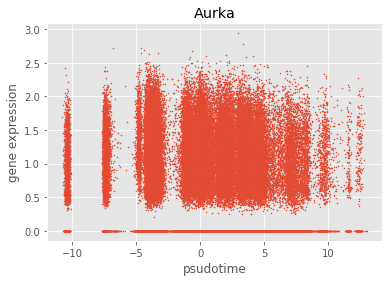

In [171]:
plt.scatter(gastrulation.obs['cellcycle_pseudotime'],CellCyclegastrulation["Aurka"],s=1 )#G2,M  M phase
plt.title('Aurka')
plt.xlabel('psudotime')
plt.ylabel('gene expression')

Text(0, 0.5, 'gene expression')

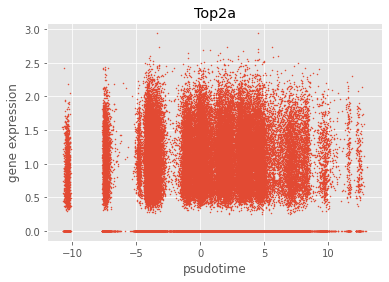

In [172]:
plt.scatter(gastrulation.obs['cellcycle_pseudotime'],CellCyclegastrulation["Top2a"], s=1 )#G1 Phase gene 
plt.title('Top2a')
plt.xlabel('psudotime')
plt.ylabel('gene expression')

Text(0, 0.5, 'gene expression')

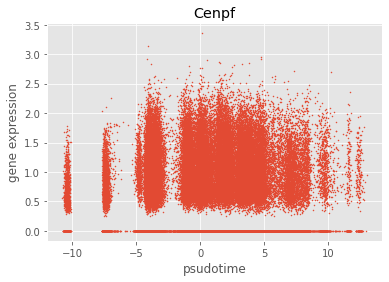

In [173]:
plt.scatter( gastrulation.obs['cellcycle_pseudotime'],CellCyclegastrulation["Cenpf"],s=1 )# 'Arl6ip1', 'Cdk1'
plt.title('Cenpf')
plt.xlabel('psudotime')
plt.ylabel('gene expression')

Text(0, 0.5, 'gene expression')

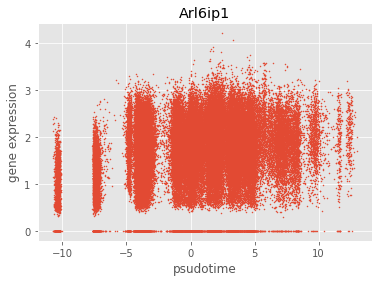

In [174]:
plt.scatter( gastrulation.obs['cellcycle_pseudotime'],CellCyclegastrulation['Arl6ip1'],s=1 )# , 'Cdk1'
plt.title('Arl6ip1')
plt.xlabel('psudotime')
plt.ylabel('gene expression')

Text(0, 0.5, 'gene expression')

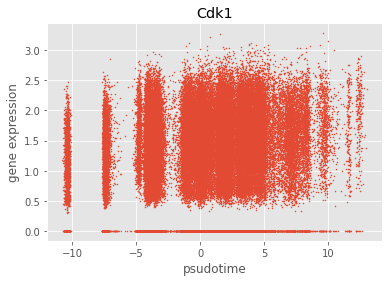

In [175]:
plt.scatter( gastrulation.obs['cellcycle_pseudotime'],CellCyclegastrulation['Cdk1'],s=1 )
plt.title('Cdk1')
plt.xlabel('psudotime')
plt.ylabel('gene expression')

Cell Cycle Genes for hemaetopoetic cells 

Step 1: Find informative cell-cycle marker genes

### 2. When we exclude the latent variable capturing the cell cycle, does this reduce separation between cells in different stages in clustering?

For this analysis we start by using the pancreas dataset in the scvelo package, where we observed that the clustering and embedding based on PCA still retains separation between cells driven by proliferation (are there more datasets like this?).

We want to evaluate whether excluding the cell cycle latent variable creates a reduced dimensionality space where cells with the same label but different proliferation status are well mixed, while still maintaining differences. We need to define a metric to quantify mixing (examples metrics to quantify batch mixing [here](https://github.com/theislab/scib#metrics)). 

In [ ]:
## Code to identify proliferating cells

In [200]:
gastrulation

AnnData object with n_obs × n_vars = 89267 × 1488
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'PCA', 'gplvm_PCA', 'hvg', 'leiden', 'likelihood_state_dict', 'model_state_dict', 'pca', 'umap'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_gplvm_PC', 'X_umap_gplvm_random', 'X_umap_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_connectivities', 'PCA_distances', 'gplvm_PCA

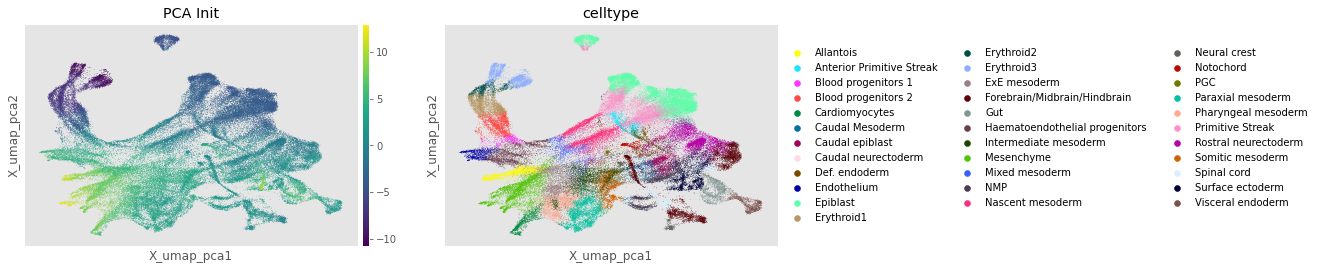

In [206]:
gp_pca=sc.pl.embedding(gastrulation, 'X_umap_pca', color=['cellcycle_pseudotime', 'celltype'], components=['1,2'], title="PCA Init")

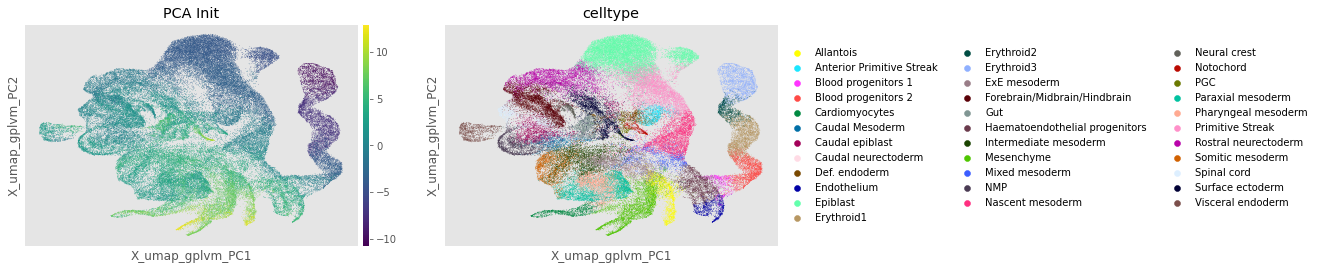

In [207]:
gp_pca=sc.pl.embedding(gastrulation, 'X_umap_gplvm_PC', color=['cellcycle_pseudotime', 'celltype'], components=['1,2'], title="PCA Init")

In [ ]:
## Code to quantify mixing between proliferating cells of the same type

As an additional positive control, we can check how much the mixing is reduced if we do include the cell cycle latent variable

Unscaled Data

In [80]:
gastrulation_unscaled=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/UnscaledvsScaled/gastrulation_unscaled_pca.h5ad')
gastrulation_unscaled_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/UnscaledvsScaled/gastrulation_unscaled_random.h5ad')
pancreas_unscaled=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/UnscaledvsScaled/pancreas-unscaled-pca.h5ad')
pancreas_unscaled_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/UnscaledvsScaled/pancreas-unscaled_random.h5ad')
pbmc10k_unscaled=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/UnscaledvsScaled/pbmc10k_unscaled_pca.h5ad')
pbmc10k_unscaled_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/UnscaledvsScaled/pbmc10k-unscaled_random.h5ad')
pbmc3k_unscaled=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/UnscaledvsScaled/pbmc3k-unscaled-pca.h5ad')
pbmc3k_unscaled_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/UnscaledvsScaled/pbmc3k-unscaled-random.h5ad')
plot_umap(gastrulation_unscaled,gastrulation_unscaled_random)
plot_umap(pancreas_unscaled,pancreas_unscaled_random)
plot_umap(pbmc10k_unscaled,pbmc10k_unscaled_random)
plot_umap(pbmc3k_unscaled,pbmc3k_unscaled_random)

In [83]:
gastrulation

AnnData object with n_obs × n_vars = 89267 × 1488
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'PCA', 'gplvm_PCA', 'hvg', 'leiden', 'likelihood_state_dict', 'model_state_dict', 'pca', 'umap'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_gplvm_PC', 'X_umap_gplvm_random', 'X_umap_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_connectivities', 'PCA_distances', 'gplvm_PCA

In [95]:
pancreas_unscaled.obs['celltype']=pancreas_unscaled.obs['clusters']
pbmc10k_unscaled.obs['celltype']=pbmc10k_unscaled.obs['predicted.celltype.l2']
pbmc3k_unscaled.obs['celltype']=pbmc3k_unscaled.obs['predicted.celltype.l2']

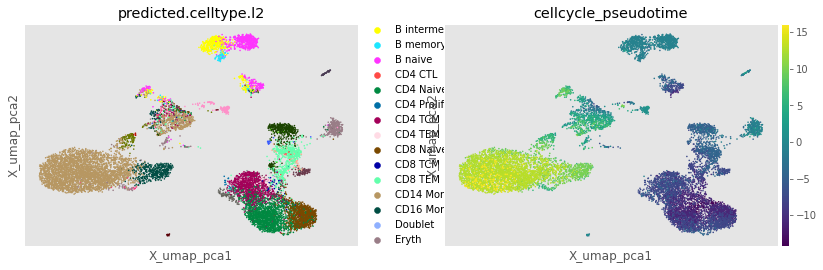

In [84]:
sc.pl.embedding(pbmc10k_unscaled, "X_umap_pca", color=[ 'predicted.celltype.l2', 'cellcycle_pseudotime'])

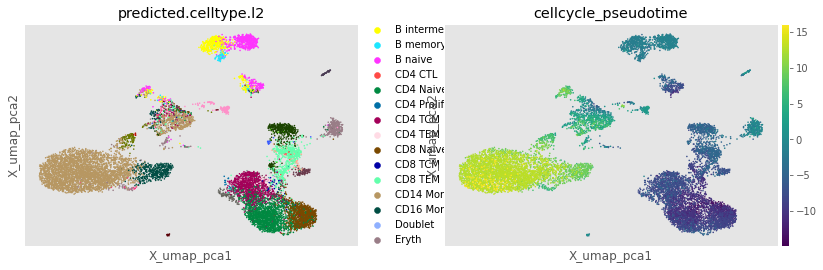

In [86]:
sc.pl.embedding(pbmc10k, "X_umap_pca", color=[ 'predicted.celltype.l2', 'cellcycle_pseudotime'])

In [89]:
pbmc10k.obs['cellcycle_pseudotime']

AAACAGCCAAAGCCTC-1   -13.411034
AAACAGCCAGAATGAC-1     9.540802
AAACAGCCAGCTACGT-1    12.542161
AAACAGCCAGGCCTTG-1     9.795949
AAACAGCCATAAGGAC-1    -0.594552
                        ...    
TTTGTGTTCTAGCTAA-1   -11.682448
TTTGTTGGTACGCGCA-1   -10.421573
TTTGTTGGTATTTGCC-1    12.897497
TTTGTTGGTGATTACG-1   -10.349260
TTTGTTGGTTTCAGGA-1   -11.627477
Name: cellcycle_pseudotime, Length: 12016, dtype: float32

In [90]:
pbmc10k_unscaled.obs['cellcycle_pseudotime']

AAACAGCCAAAGCCTC-1   -10.851133
AAACAGCCAGAATGAC-1     9.476977
AAACAGCCAGCTACGT-1    13.020591
AAACAGCCAGGCCTTG-1     9.260160
AAACAGCCATAAGGAC-1    -0.844300
                        ...    
TTTGTGTTCTAGCTAA-1   -10.900779
TTTGTTGGTACGCGCA-1   -10.871858
TTTGTTGGTATTTGCC-1    12.860394
TTTGTTGGTGATTACG-1   -10.740056
TTTGTTGGTTTCAGGA-1   -10.939842
Name: cellcycle_pseudotime, Length: 12016, dtype: float32

In [91]:
pancreas_unscaled.obs['cellcycle_pseudotime']

index
AAACCTGAGAGGGATA    -7.205275
AAACCTGAGCCTTGAT    10.261789
AAACCTGAGGCAATTA    -6.646129
AAACCTGCATCATCCC     9.925273
AAACCTGGTAAGTGGC    -1.079399
                      ...    
TTTGTCAAGTGACATA    -7.148183
TTTGTCAAGTGTGGCA     1.750784
TTTGTCAGTTGTTTGG    10.185785
TTTGTCATCGAATGCT    -6.680949
TTTGTCATCTGTTTGT    -6.773817
Name: cellcycle_pseudotime, Length: 3696, dtype: float32

In [92]:
pancreas.obs['cellcycle_pseudotime']

index
AAACCTGAGAGGGATA    -7.519101
AAACCTGAGCCTTGAT    10.054272
AAACCTGAGGCAATTA    -7.437848
AAACCTGCATCATCCC     9.475479
AAACCTGGTAAGTGGC    -1.388618
                      ...    
TTTGTCAAGTGACATA    -7.387690
TTTGTCAAGTGTGGCA     1.657835
TTTGTCAGTTGTTTGG     9.991168
TTTGTCATCGAATGCT    -6.717700
TTTGTCATCTGTTTGT    -9.863447
Name: cellcycle_pseudotime, Length: 3696, dtype: float32

In [96]:
ds = [gastrulation_unscaled,pancreas_unscaled, pbmc10k_unscaled, pbmc3k_unscaled]
names= ['gastrulation','pancreas', 'pbmc10k', 'pbmc3k']
RandScore= pd.DataFrame(columns=['condition', 'score', 'dataset'] )
for i in range(len(ds)):
    adata = ds[i]
    name= names[i]
    RS = randScore(adata, name)
    #print(ARI)
    RandScore= pd.concat([RandScore,RS]) 
RandScore["Metric"]= "ARI"
    

In [97]:
RandScore

condition     score       dataset Metric
0  random_init  0.260815  gastrulation    ARI
1   gplvm_init  0.519773  gastrulation    ARI
2          pca  0.400743  gastrulation    ARI
0  random_init  0.318602      pancreas    ARI
1   gplvm_init  0.287714      pancreas    ARI
2          pca  0.446681      pancreas    ARI
0  random_init  0.297922       pbmc10k    ARI
1   gplvm_init  0.269363       pbmc10k    ARI
2          pca  0.473883       pbmc10k    ARI
0  random_init  0.380585        pbmc3k    ARI
1   gplvm_init  0.438410        pbmc3k    ARI
2          pca  0.530390        pbmc3k    ARI

In [98]:
ds = [gastrulation_unscaled,pancreas_unscaled, pbmc10k_unscaled, pbmc3k_unscaled]
names= ['gastrulation','pancreas', 'pbmc10k', 'pbmc3k']
NMI= pd.DataFrame(columns=['condition', 'score', 'dataset'] )
for i in range(len(ds)):
    adata = ds[i]
    name= names[i]
    NMS = NMI_Scores(adata, name)
    #print(ARI)
    NMI= pd.concat([NMI,NMS]) 
NMI["Metric"]= "NMI"
    

In [99]:
NMI

condition     score       dataset Metric
0  random_init  0.559229  gastrulation    NMI
1   gplvm_init  0.744396  gastrulation    NMI
2          pca  0.694095  gastrulation    NMI
0  random_init  0.580684      pancreas    NMI
1   gplvm_init  0.567391      pancreas    NMI
2          pca  0.639743      pancreas    NMI
0  random_init  0.593535       pbmc10k    NMI
1   gplvm_init  0.573986       pbmc10k    NMI
2          pca  0.684979       pbmc10k    NMI
0  random_init  0.688927        pbmc3k    NMI
1   gplvm_init  0.705584        pbmc3k    NMI
2          pca  0.736289        pbmc3k    NMI

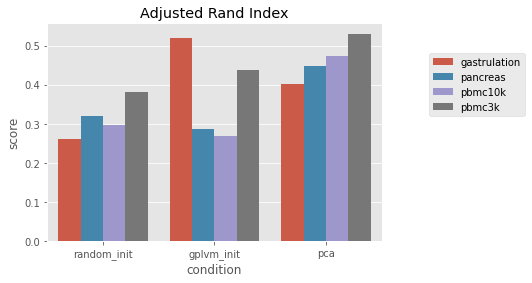

In [100]:
ax = sns.barplot(x="condition", y="score", hue="dataset",
                 data=RandScore, linewidth=2.5)
#plt.legend(loc='upper left')
plt.title("Adjusted Rand Index")
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=3.)

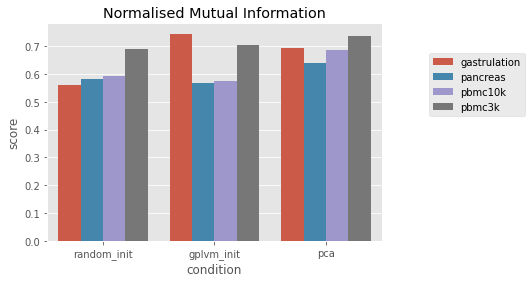

In [101]:
ax = sns.barplot(x="condition", y="score", hue="dataset",
                 data=NMI, linewidth=2.5)
#plt.legend(loc='upper left')
plt.title("Normalised Mutual Information")
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=3.)